In [2]:
# Import the other required packages and modules.
import pandas as pd
import datetime
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search


# From the IPython.display package, import display and Markdown
from IPython.display import display, Markdown

import torchvision

/Users/prasannasundar/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#read data
runway = pd.read_csv("runway.csv",parse_dates=['review_date']) # parse column as datetime for visualization  
print(runway.info())

print(runway.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB
None
   user_id  item_id  rating     rented for  \
0   476109   139086       8  formal affair   
1   203660  1126889       6          party   
2   868581   652189       8        wedding   
3   935076  1879504       8      

In [4]:
## Pre Processing

#remove forward slash 

runway['review_text_cleaned']=runway['review_text'].str.replace(r"\/","")

#remove punctuation
runway['review_text_cleaned']=runway['review_text_cleaned'].str.translate(string.punctuation)


#remove digits
runway['review_text_cleaned']=runway['review_text_cleaned'].str.replace(r"\d+","")

#remove running spaces

runway['review_text_cleaned']=runway['review_text_cleaned'].str.replace(r"\s{2,}","")  #removing 2 or more spaces
#make text lowercase
runway['review_text_cleaned']=runway['review_text_cleaned'].str.lower()

In [6]:
runway['review_text_cleaned'][4]

'super flattering i am usually a sizemi have a dd chest and this dress was so flattering on'

## Sentiment Analysis

In [5]:
#bert based model for sentiment analysis
senti_model = "distilbert-base-uncased-finetuned-sst-2-english" 


#instantiate new pipeline object

sentimentAnalysis = pipeline("sentiment-analysis",model=senti_model)

# Run on cleaned review text


sent_analysis_output = sentimentAnalysis(list(runway["review_text_cleaned"]))

## Histogram of Sentiment Score




Text(0.5, 1.0, 'For Clean Review Text')

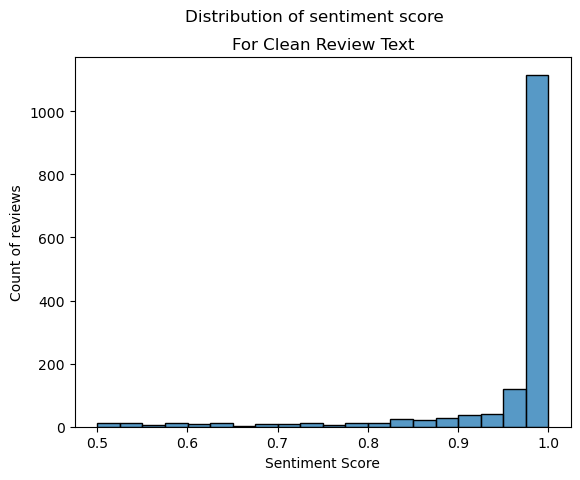

In [9]:

#parse output as sentiment category label and score
runway['clean_sentiment_category'] = [s['label'] for s in sent_analysis_output]
runway['clean_sentiment_score'] = [s['score'] for s in sent_analysis_output]



sns.histplot(data=runway,x="clean_sentiment_score",bins=20)

plt.suptitle("Distribution of sentiment score")

plt.xlabel("Sentiment Score")

plt.ylabel("Count of reviews")


plt.title("For Clean Review Text")

In [ ]:
#insight
# Most reviews are positive

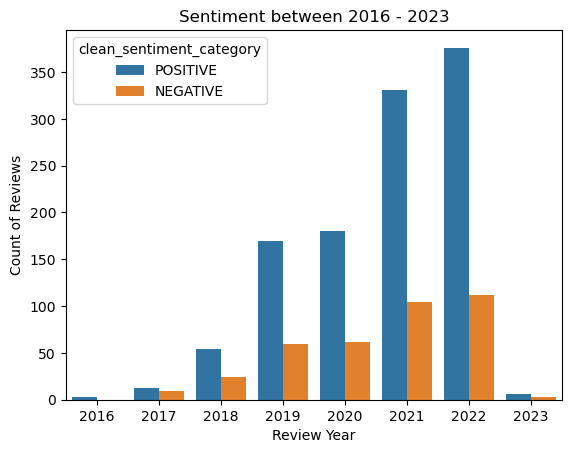

In [19]:
#analyze reviews by year

chart_data = runway.groupby(['year', 'clean_sentiment_category'], as_index=False)['user_id'].count()
chart_data.columns = ['year', 'clean_sentiment_category', 'cnt']

# Create a bar plot showing the count of reviews for each sentiment category over the years.
sns.barplot(data=chart_data, x="year", y="cnt", hue="clean_sentiment_category", errorbar = None)
plt.title("Sentiment between 2016 - 2023")
plt.xlabel("Review Year")
plt.ylabel("Count of Reviews")
plt.show()

In [20]:
# Reviews have increased every year until 2022. The % of positive reviews also has been on an increeasing trend. 2021 was a game changer!

,year,clean_sentiment_category,cnt
0,2016,POSITIVE,3
1,2017,NEGATIVE,9
2,2017,POSITIVE,12
3,2018,NEGATIVE,24
4,2018,POSITIVE,54
5,2019,NEGATIVE,60
6,2019,POSITIVE,170
7,2020,NEGATIVE,62
8,2020,POSITIVE,180
9,2021,NEGATIVE,104


In [24]:
# check if unprocessed review data makes any difference for the sentiment category



sent_analysis_output2 = sentimentAnalysis(list(runway["review_text"]))


#parse output as sentiment category label and score
runway['clean_sentiment_category2'] = [s['label'] for s in sent_analysis_output2]
runway['clean_sentiment_score2'] = [s['score'] for s in sent_analysis_output2]


In [26]:
# confusion matrix

display( pd.crosstab(runway['clean_sentiment_category2'],runway['clean_sentiment_category2']))


display( pd.crosstab(runway['clean_sentiment_category'],runway['clean_sentiment_category']))

clean_sentiment_category2,NEGATIVE,POSITIVE
clean_sentiment_category2,,
NEGATIVE,375,0
POSITIVE,0,1131


clean_sentiment_category,NEGATIVE,POSITIVE
clean_sentiment_category,,
NEGATIVE,374,0
POSITIVE,0,1132


In [ ]:
''' insight: we got almost same sentiment category from unprocessed review data.
this is because the transformers model BERT  uses self attention and gains context from sequences in texts, This allows the models to  work well with text as is and unstructured,
For this particular application we can use unprocessed data '''

In [6]:
# text embeddings
model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Instantiate a new SentenceTransformer object.
model = SentenceTransformer(model_id)

# Generate the embeddings for the "rented for" column.
embeddings = model.encode(list(runway["rented for"]))

print(embeddings.shape)




(1506, 384)


## Semantic Search

In [7]:
# Define query
query = "a gorgeous and flattering dress"

# Embed query
query_emb = model.encode(query, convert_to_tensor=True)

# Calculate similarity between query and item embeddings
hits = semantic_search(query_emb, embeddings, top_k=3)


ITEM ID:  652189 ; RENTED FOR:  wedding ; REVIEW even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant wear a bra and because the neck is such a scoopneck it makes the neckline a little strange if you have a chest and dont wear onei ended up getting one of those stick on bras and the dress looked much betterits much pinker than the model picture which was a pleasant surprisepretty dress comfortable just a little awkward fitting in the chest area if you have anything larger than an abuy the stick on bra
ITEM ID:  1498329 ; RENTED FOR:  wedding ; REVIEW the dress was gorgeous but unfortunately i was unable to wear it due to some quality issues which the renttherunway team was excellent at handlingi would recommend going upsizes from your usual dress size if you have a larger bustit also runs on the long side imand even withinch heels it dragged a little too much for my preferencethe colou

In [13]:

# Print top similar items
for hit in hits[0]:
    idx = hit['corpus_id']
    display(
        "ITEM ID: ", runway.iloc[idx]['item_id'], 
        "; RENTED FOR: ", runway.iloc[idx]['rented for'],
        "; REVIEW", runway.iloc[idx]['review_text'],
        "; clean_sentiment_category", runway.iloc[idx]['clean_sentiment_category'])

'ITEM ID: '

652189

'; RENTED FOR: '

'wedding'

'; REVIEW'

'even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant wear a bra and because the neck is such a scoopneck it makes the neckline a little strange if you have a chest and dont wear onei ended up getting one of those stick on bras and the dress looked much betterits much pinker than the model picture which was a pleasant surprisepretty dress comfortable just a little awkward fitting in the chest area if you have anything larger than an abuy the stick on bra'

'; clean_sentiment_category'

'NEGATIVE'

'ITEM ID: '

1498329

'; RENTED FOR: '

'wedding'

'; REVIEW'

'the dress was gorgeous but unfortunately i was unable to wear it due to some quality issues which the renttherunway team was excellent at handlingi would recommend going upsizes from your usual dress size if you have a larger bustit also runs on the long side imand even withinch heels it dragged a little too much for my preferencethe colours are rich and true to the picture the fabric is forgiving when it comes to wrinkles so its a dress that travels very well'

'; clean_sentiment_category'

'POSITIVE'

'ITEM ID: '

1879504

'; RENTED FOR: '

'wedding'

'; REVIEW'

'this dress was greatit fit really well and was very comfortablethe only negative is that the length is a little odd so it made walking up stairs and getting into the car a little difficultimlbs and the medium fit perfectly'

'; clean_sentiment_category'

'POSITIVE'